In [1]:
import os
import sys
import yaml 

import torch
from kornia.feature import SIFTDescriptor
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory import get_datasets

class SIFTDescriptor(SIFTDescriptor):
    def describe_image_sift(self, image):
        image = image.unfold(-2, self.patch_size, self.patch_size)\
            .unfold(-2, self.patch_size, self.patch_size)
        descs = self(image.reshape(-1, 1, self.patch_size, self.patch_size))
        return descs
    


In [21]:
def zncc(x1, x2, return_absolute = True):
    """
    Computes the Zero Mean Normalized Cross Correlation (ZNCC) between two images.
    
    Args:
        x1 (torch.Tensor): The first image tensor of shape (B, C, H, W), where B is the batch size, C is the number of channels, and H and W are the height and width of the image respectively.
        x2 (torch.Tensor): The second image tensor of the same shape as x1.
        
    Returns:
        torch.Tensor: A tensor of shape (B) containing the ZNCC values for each pair of corresponding images in x1 and x2.
    """
    # Compute means and standard deviations along channel dimension
    mu_x1 = x1.mean((2,3), keepdim=True)
    mu_x2 = x2.mean((2,3), keepdim=True)
    
    # Ensure nonzero stddev to avoid division by zero
    # nonzero_mask = sigma_x1.gt(0).type(sigma_x1.dtype) & sigma_x2.gt(0).type(sigma_x2.dtype)
    # x1 = x1 * nonzero_mask
    # x2 = x2 * nonzero_mask
    # mu_x1 = mu_x1 * nonzero_mask
    # mu_x2 = mu_x2 * nonzero_mask
    
    # Subtract means and divide by standard deviations
    x1_zm = (x1 - mu_x1)
    x2_zm = (x2 - mu_x2) 

    # Compute dot product and normalize by square root of sum of squares
    dp = torch.sum(x1_zm * x2_zm, dim=(1,2,3))
    norm = torch.sqrt(torch.sum(x1_zm**2, dim=(1,2,3))) * torch.sqrt(torch.sum(x2_zm**2, dim=(1,2,3)))
    zncc = dp / (norm + 1e-8)
    
    if return_absolute:
        zncc = torch.sqrt(zncc**2)

    return zncc

In [22]:
def sift_descriptor_loss(descs1, descs2):
    # calculate rmse between two sets of sift descriptors
    return torch.sqrt(torch.mean((descs1 - descs2) ** 2))

def zncc_loss(x1, x2):
    return 1 - zncc(x1, x2).mean()

In [23]:
dataset_params = yaml.load(open('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/datasets.yaml', 'r'), Loader=yaml.FullLoader)
dataset_params = dataset_params['umc']

# Load an example dataset

In [24]:
(ds_train,) = get_datasets(
        splits          = ['train'],
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (1, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        bg_suppression_opts = None
    )

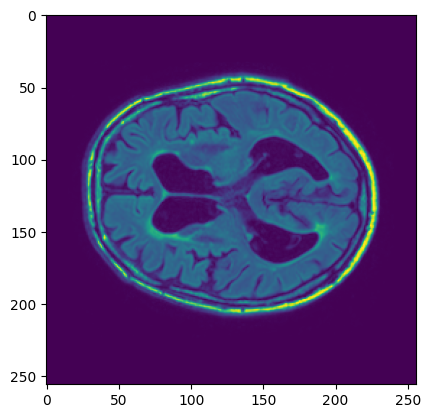

In [25]:
plt.imshow(ds_train[24][0][0])

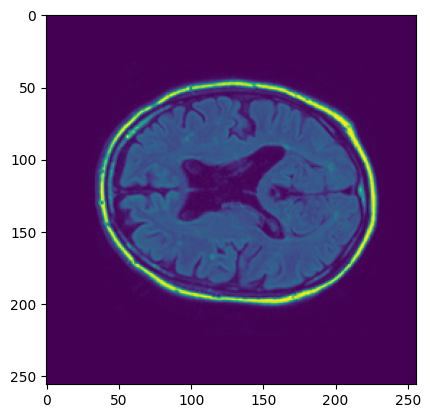

In [26]:
plt.imshow(ds_train[27 + 48][0][0])

In [27]:
sift = SIFTDescriptor(256, 8, 16)
sift.describe_image_sift(ds_train[24][0][0]).shape

torch.Size([1, 2048])

## Check how it behaves for random tensors

In [28]:
sift = SIFTDescriptor(256, 8, 16)
#sift = SIFTDescriptor(16, 8, 4)
sift.describe_image_sift(ds_train[24][0][0][None, None, ...]).shape

torch.Size([1, 2048])

In [29]:
n_samples = 50
total_loss_sift = 0
total_loss_zncc = 0

for _ in range(n_samples):
    rand_img = torch.rand(1, 1, 256, 256)
    total_loss_sift += (sift_desc_loss(sift.describe_image_sift(ds_train[24][0][None, ...]), sift.describe_image_sift(rand_img)))
    total_loss_zncc += zncc_loss(ds_train[24][0][None, ...], rand_img)

print('total_loss_sift: ', total_loss_sift / n_samples)
print('total_loss_zncc: ', total_loss_zncc / n_samples)

total_loss_sift:  tensor(0.0173, grad_fn=<DivBackward0>)
total_loss_zncc:  tensor(0.9971)


In [30]:
# Compared to only background image
sift_desc_loss(sift.describe_image_sift(ds_train[24][0][0][None, None, ...]),
               sift.describe_image_sift(ds_train[48 + 0][0][0][None, None, ...]))

tensor(0.0140, grad_fn=<SqrtBackward0>)

In [31]:
# Compared to only background image
zncc_loss(ds_train[24][0][0][None, None, ...], ds_train[48 + 0][0][0][None, None, ...])

tensor(0.6013)

In [32]:
# Compared to similar image
sift_desc_loss(sift.describe_image_sift(ds_train[24][0][0][None, None, ...]),
               sift.describe_image_sift(ds_train[48 + 27][0][0][None, None, ...]))


tensor(0.0078, grad_fn=<SqrtBackward0>)

In [33]:
zncc_loss(ds_train[24][0][0][None, None, ...], ds_train[48 + 27][0][0][None, None, ...])

tensor(0.4296)

# Check how the losses would behave under small translations and rotations of the image

In [ ]:
aug_params = {
    "da_ratio": 0.25,
    "sigma": 20,
    "alpha": 0,
    "trans_min": 0,
    "trans_max": 0,
    "rot_min": 0,
    "rot_max": 0,
    "scale_min": 1.0,
    "scale_max": 1.0,
    "gamma_min": 0.5,
    "gamma_max": 2.0,
    "brightness_min": 0.0,
    "brightness_max": 0.1,
    "noise_mean": 0.0,
    "noise_std": 0.1 
}

# Generate Images with regular augmentations

# Generate Images with very distorting augmentations

# Check how they behave with increasing augmentation strength